# Comparing beamconv and ducc
In this script, we run some tests to verify the good agreement of the time-ordered data (TOD) returned by ducc and beamconv.

Note that there are some discrepancies in the conventions assumed by the two codes. In particular,
- $\psi_\texttt{beamconv} = 180 - \psi_\texttt{ducc}$;
- If $q_\texttt{beamconv}=\{q_0,q_1,q_2,q_3\}$, ducc seems to need $q_\texttt{ducc} = \{-q_1,q_2,q_3,q_0\}$.

Everytime we deal with these discrepancies in the code, we'll highlight it with a <tt>#CONVENTIONS!</tt> comment.

## 1. One boresight detector

First, we consider the simpler case of a detector at boresight.

### Everything random

This section is based on [comparison_script.py](https://github.com/AdriJD/beamconv/blob/muellerconvolver_comparison/comparison_script.py) from the muellerconvolver_comparison branch of beamconv. We consider random scanning strategy, beams and HWP Mueller matrix and compare the TOD.

We import a few useful libraries.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import mueller_convolver
import ducc0
import utils

from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

import scanning_mod

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

And set up some variables.

In [2]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))

nside = 64
lmax = 2*nside
kmax = 18
npix = 12*nside**2

We define <b>completely random beam, sky spherical harmonics coefficients and HWP Mueller matrix</b>.

In [3]:
# completely random beam
random_blm = utils.make_full_random_alm(lmax, kmax, rng)
# completely random sky
random_slm = utils.make_full_random_alm(lmax, lmax, rng)
# completely random Mueller matrix
random_mueller = np.random.uniform(-1,1,size=(4,4))

To keep our test as general as possible, we define some <b>completely random pointings</b>

In [4]:
nptg=100
random_ptg = np.empty((nptg,3))
random_ptg[:,0]=np.random.uniform(0,np.pi,size=(nptg,))       # theta
random_ptg[:,1]=np.random.uniform(0,2*np.pi,size=(nptg,))     # phi
random_ptg[:,2]=np.random.uniform(0,2*np.pi,size=(nptg,))     # psi
random_hwp_angles = np.random.uniform(0,2*np.pi,size=(nptg,)) # alpha

Given the specifics we just introduced, we can simulate the TOD by means of the <tt>get_beamconv_values</tt> function defined in utils.py. Note that, because the different conventions used in qpoint and MuellerConvolver, <tt>psi_beamconv = 180. - np.degrees(ptg_ducc[:,2])</tt>!

In [5]:
# get the signal from beamconv
signal_beamconv_TT = utils.get_beamconv_values(lmax=lmax, kmax=kmax, slm=random_slm, blm=random_blm, 
                                               ptg=random_ptg, hwp_angles=random_hwp_angles, mueller=random_mueller, 
                                               mu_con_hwp=True, mu_con_spin=True)

In [6]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=random_blm,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=random_ptg, alpha=random_hwp_angles)

del(fullconv)

To compare the two TOD, we print the L2 error and plot them, together with their difference.

In [7]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv_TT, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.0077483096084764455


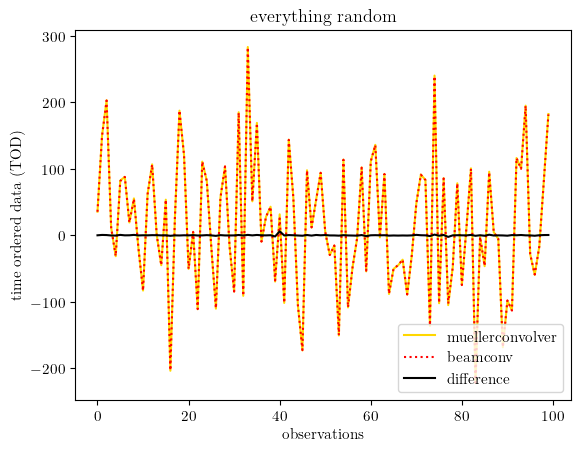

In [8]:
diff = signal_muellerconvolver-signal_beamconv_TT

# plotting diff
plt.plot(signal_muellerconvolver, color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT, color='red', linestyle=':', label="beamconv")
plt.plot(diff, color='black', label="difference")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random')
plt.show()

The small discrepancies between the two TOD arise from the fact that we are running ducc with nside=64, while beamconv internally assumes nside=256. If we increase nside, the discrepancies get lower. <font color="red">[Is it true? Shouldn't I show it?]</font>

### Gaussian beam (instead of random)

Also, <font color="red">[...]</font>

In [12]:
fwhm_arcmin = 5.
fwhm_rad = np.radians(fwhm_arcmin/60.)

# completely random beam
blm_gauss = utils.make_full_random_alm(lmax, kmax, rng)

# ... or use a Gauss beam
blmtmp = utils.blm_gauss_new(fwhm_rad,lmax,pol=True)
blm_gauss *= 0
blm_gauss[0:3, 0:blmtmp.shape[1]] = blmtmp

In [14]:
# get the signal from beamconv
signal_beamconv_TT = utils.get_beamconv_values(lmax=lmax, kmax=kmax, slm=random_slm, blm=blm_gauss, 
                                         ptg=random_ptg, hwp_angles=random_hwp_angles, mueller=random_mueller, 
                                         mu_con_hwp=True, mu_con_spin=True)

In [15]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=random_ptg, alpha=random_hwp_angles)

del(fullconv)

In [16]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv_TT, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.0031168161395581763


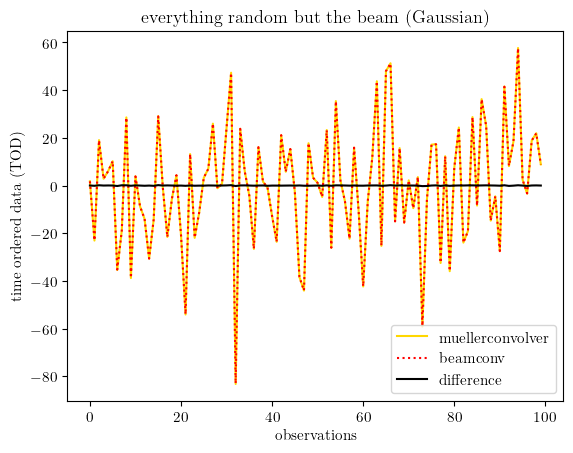

In [17]:
# plotting diff
plt.plot(signal_muellerconvolver, color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT, color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver-signal_beamconv_TT, color='black', label="difference")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random but the beam (Gaussian)')
plt.show()

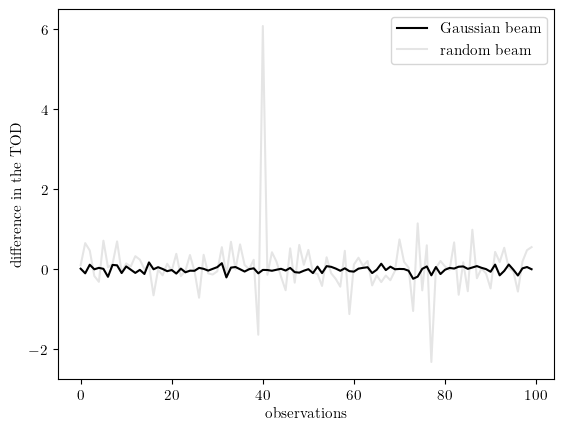

In [18]:
# plotting diff
plt.plot(signal_muellerconvolver-signal_beamconv_TT, color='black', label="Gaussian beam")
plt.plot(diff, color='black', alpha=0.1, label="random beam")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('difference in the TOD')
plt.show()

### Dummy scanning strategy (instead of random)

In [19]:
duration = 3600*24                    # mission duration in s (1 day)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

t_samp_array = np.arange(nsamp)/fsamp # array of the sampled times

def ctime_test(**kwargs):
    return np.zeros(kwargs.pop('end')-kwargs.pop('start'))

In [20]:
ptg = np.empty((nsamp,3))             # initializing pointings array
ptg[:,0]=np.pi*np.arange(nsamp)/nsamp # theta
ptg[:,1]=np.radians(55.66)            # phi
ptg[:,2]=np.arange(nsamp)*1e-4        # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
# Adjustment for difference in convention between qpoint and MuellerConvolver?
psi = 180. - np.degrees(ptg[:,2]) #CONVENTIONS!

# calculate the boresight quaternions
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

In [21]:
# provide HWP stuff
hwp_angles = np.arange(nsamp)*1e-5

In [22]:
ndet = 1

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
deads = np.array([[0,1]])

from line 4556 of instrument.py: [1. 0. 0. 0.]


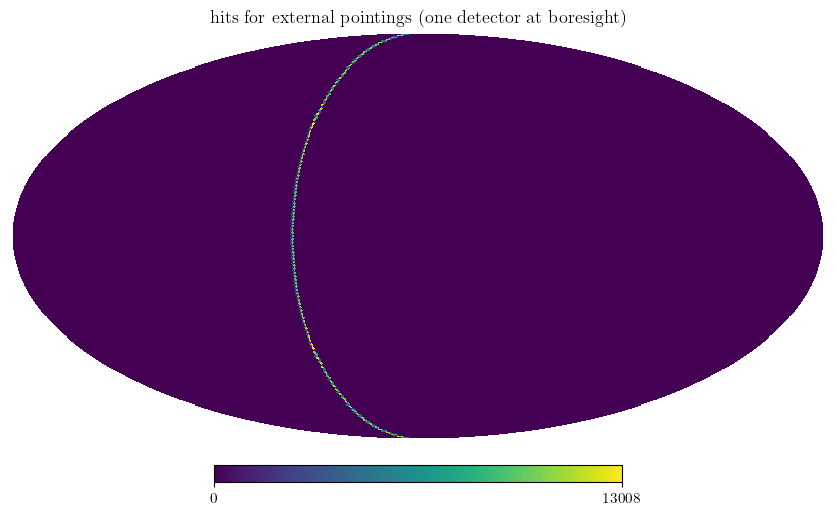

In [23]:
# prepare PO beam file
blm2 = np.zeros((blm_gauss.shape[0], hp.Alm.getsize(lmax=lmax)), dtype=np.complex128)
blm2[:,:blm_gauss.shape[1]] = blm_gauss
blmm, blmp = tools.eb2spin(blm2[1],blm2[2])
blm2[1] = blmm
blm2[2] = blmp
np.save("gaussian_beam.npy", blm2)

# setting up the beam options
beam_opts_boresight = dict(btype='PO',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           po_file="gaussian_beam.npy",
                           hwp_mueller=random_mueller)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=hwp_angles*180/np.pi)

# determine nside_spin necessary for good accuracy
nside_spin = 1
while nside_spin < 4*lmax:
    nside_spin *= 2

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (one detector at boresight)')

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

In [24]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg[:500000], alpha=hwp_angles[:500000])

del(fullconv)

In [25]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv[:500000], signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.020739498874581923


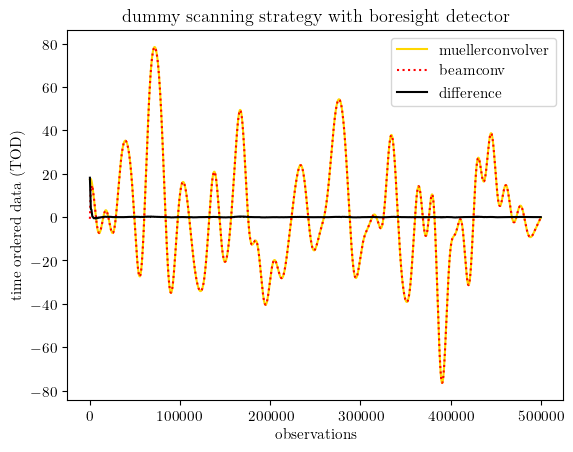

In [26]:
# plotting diff
plt.plot(signal_muellerconvolver[:500000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[:500000], color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver[:500000]-signal_beamconv[:500000], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with boresight detector')
plt.show()

In [27]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv[10000:500000], signal_muellerconvolver[10000:]))

L2 error to beamconv + HWP + spin: 0.0029460746681002487


## 2. Offset detector (instead of boresight)

<a style="color:Red;">TODO: explain whatever is happening from here on</a>

In [28]:
off_quats = np.zeros((ndet,2,4))

off_ra, off_dec, off_pa = 10., 87., 10.
off_quats[0,0,:] = qp.QPoint().radecpa2quat(off_ra, off_dec, off_pa)

from line 4556 of instrument.py: [-2.77555756e-17  2.57792616e-02  4.54557937e-03  9.99657325e-01]


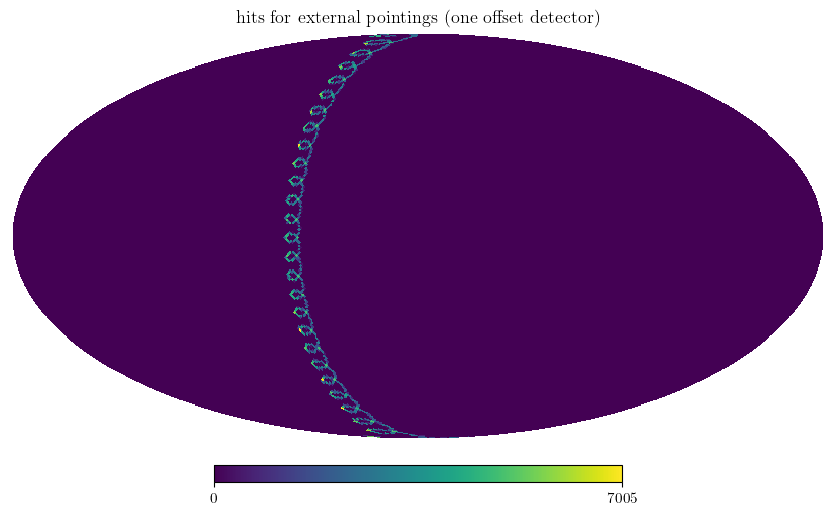

In [29]:
# setting up the beam options
beam_opts_quats = dict(btype='PO',
                       lmax=lmax,
                       mmax=lmax,
                       deconv_q=True,
                       normalize=False,
                       po_file="gaussian_beam.npy",
                       hwp_mueller=random_mueller,
                       quats=off_quats)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_quats)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=hwp_angles*180/np.pi)

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (one offset detector)')

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

In [30]:
ptg4ducc = np.copy(ptg)

q_bore_ducc = ducc0.misc.ptg2quat(ptg4ducc)

off_quat = np.roll(off_quats[0,0],-1) #CONVENTIONS!
off_quat[0] *= -1                     #CONVENTIONS!

new_quats = np.empty((nsamp,4))

pp = ducc0.pointingprovider.PointingProvider(t0=0., freq=fsamp, quat=q_bore_ducc, nthreads=1)
rotated_quats = pp.get_rotated_quaternions(t0=0., freq=fsamp, rot=off_quat, rot_left=True, out=new_quats)

rotated_pointings = np.empty((nsamp, 3))

for k in np.arange(nsamp):
    rotated_pointings[k] = ducc0.misc.quat2ptg(rotated_quats[k])

In [31]:
rotated_pointings[np.where(rotated_pointings[:,1]<0),1] += 2*np.pi
rotated_pointings[np.where(rotated_pointings[:,2]<0),2] += 2*np.pi

print('theta between '+str(np.min(rotated_pointings[:,0]))+' and '+str(np.max(rotated_pointings[:,0])))
print('phi between '+str(np.min(rotated_pointings[:,1]))+' and '+str(np.max(rotated_pointings[:,1])))
print('psi between '+str(np.min(rotated_pointings[:,2]))+' and '+str(np.max(rotated_pointings[:,2])))

theta between 0.003891018376132123 and 3.1255925100043136
phi between 3.5858834732616085e-05 and 6.283149211348121
psi between 9.734115001824861e-07 and 6.2831782841795345


In [32]:
pixs = hp.ang2pix(nside, rotated_pointings[:,0], rotated_pointings[:,1])
hits1 = np.bincount(pixs,minlength=npix)

print(np.max(proj[0]-hits1))

0.0


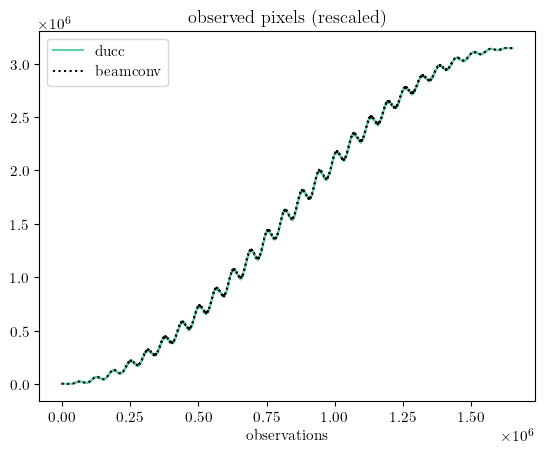

In [33]:
plt.plot(pixs*(nside_spin/nside)**2, color='mediumaquamarine', label='ducc')
plt.plot(pixels_beamconv, color='black', linestyle=':', label='beamconv')
plt.title(r'observed pixels (rescaled)')
plt.xlabel('observations')
plt.legend()
plt.show()

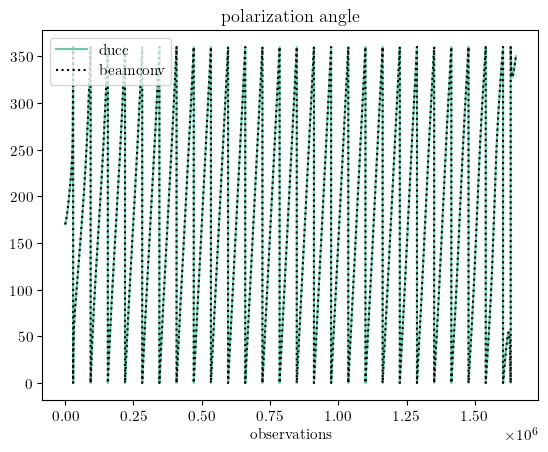

In [34]:
plt.plot(np.degrees(rotated_pointings[:,2]), color='mediumaquamarine', label='ducc')
plt.plot(pa_beamconv, color='black', linestyle=':', label='beamconv')
plt.title(r'polarization angle')
plt.xlabel('observations')
plt.legend()
plt.show()

Finally, we can try to plot the TOD. They look nice using get_beamconv_values, while they are completely off if I plot the ...

In [35]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=rotated_pointings[:500000], alpha=hwp_angles[:500000])

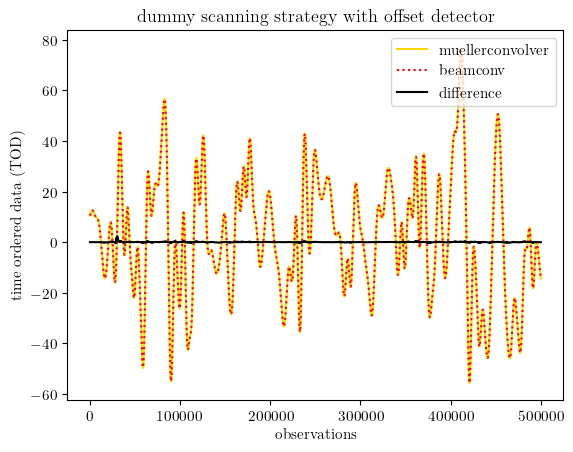

In [36]:
# plotting diff
plt.plot(signal_muellerconvolver[:500000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[:500000], color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver[:500000]-signal_beamconv[:500000], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with offset detector')
plt.show()

In [37]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv[:500000], signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.005676549587888756


## Gaussian beam from beamconv

One thing that is not necessary but might be interesting is how to reproduce beamconv's Gaussian beam with ducc. If we don't find an answer, might be worth to delete these cells.

In [38]:
# setting up the beam options
beam_opts_boresight = dict(btype='Gaussian',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           fwhm=fwhm_arcmin,
                           hwp_mueller=random_mueller)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=hwp_angles*180/np.pi)

# determine nside_spin necessary for good accuracy
nside_spin = 1
while nside_spin < 4*lmax:
    nside_spin *= 2

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=False, beam_v=False, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

from line 4556 of instrument.py: [1. 0. 0. 0.]


In [40]:
fwhm_rad = np.radians(fwhm_arcmin/60.)

# completely random beam
blm_gauss = utils.get_gauss_beam_from_beamconv(fwhm_rad, lmax)

## ... or use a Gauss beam
#blmtmp = blm_gauss_new(fwhm_rad,lmax,pol=True)
#blm_gauss *= 0
#blm_gauss[0:3, 0:blmtmp.shape[1]] = blmtmp

random_slm[3] *= 0
blm_gauss[3] *= 0

# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=rotated_pointings[:500000], alpha=hwp_angles[:500000])

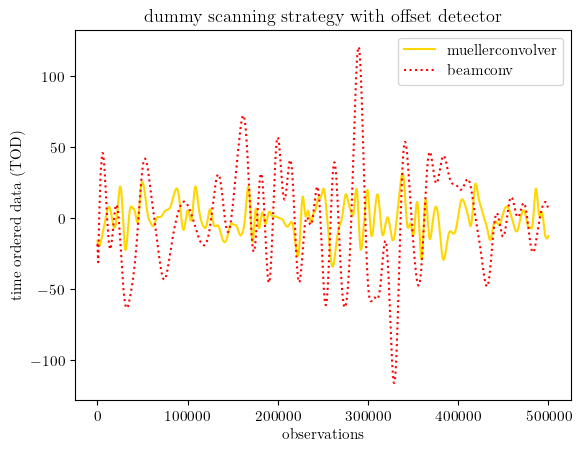

In [41]:
# plotting diff
plt.plot(signal_muellerconvolver[:500000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[:500000], color='red', linestyle=':', label="beamconv")
#plt.plot(signal_muellerconvolver[:500000]-signal_beamconv[:500000], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with offset detector')
plt.show()